Text(0.5,1,u'MRW.csv')

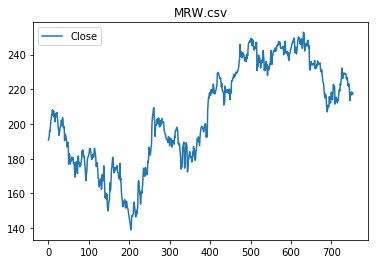

In [80]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np, numpy.random
import cvxopt as opt
from cvxopt import blas, solvers
import os, random

assets = [] # 3 random assets' expected return
# read a random file
rand_stocks = []
rand_stock = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock)
df1 = pd.read_csv('stock_dfs/'+rand_stock, usecols=['Date', 'Close'])
# df1 = pd.read_csv('stock_dfs/RRS.csv', usecols=['Date', 'Close'])
df1.plot()
plt.title(rand_stock)
# df1.head()

In [81]:
## use first half of 3 stocks to find expected return and covariances
# asset's first half expected return function
def half_expected_return(df, assets):
    df = df[:-len(df)/2] # drop second half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets.append(returns.mean())
    
    return returns
returns1 = half_expected_return(df1, assets)
# print returns1
print assets

[-0.00010634797699530027]


Text(0.5,1,u'SKY.csv')

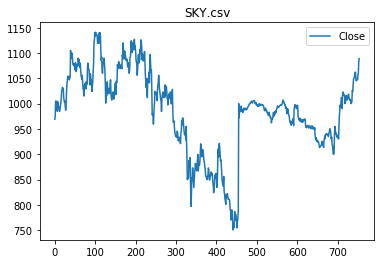

In [82]:
rand_stock2 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock2)
df2 = pd.read_csv('stock_dfs/'+rand_stock2, usecols=['Date', 'Close'])
# df2 = pd.read_csv('stock_dfs/III.csv', usecols=['Date', 'Close'])
df2.plot()
plt.title(rand_stock2)
# df2.head()

In [83]:
returns2 = half_expected_return(df2, assets)
print assets

[-0.00010634797699530027, -0.0004553740818802348]


[-0.00010634797699530027, -0.0004553740818802348, -0.0010414813957879004]


Text(0.5,1,u'LGEN.csv')

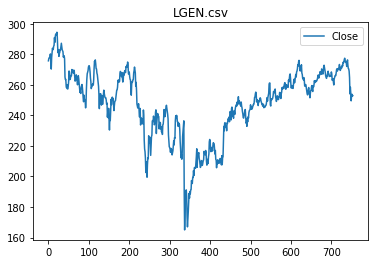

In [84]:
rand_stock3 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock3)
df3 = pd.read_csv('stock_dfs/'+rand_stock3, usecols=['Date', 'Close'])
# df3 = pd.read_csv('stock_dfs/ADM.csv', usecols=['Date', 'Close'])
returns3 = half_expected_return(df3, assets)
print assets
df3.plot()
plt.title(rand_stock3)

In [85]:
# find covariance of 3 assets
C = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C

[[0.00032962 0.00012246 0.0001873 ]
 [0.00012246 0.0002149  0.00020934]
 [0.0001873  0.00020934 0.00056031]]


     pcost       dcost       gap    pres   dres
 0:  5.4608e-04 -7.3341e+00  7e+00  6e-17  3e-16
 1:  5.4580e-04 -7.4526e-02  8e-02  2e-16  3e-16
 2:  5.1906e-04 -1.8972e-03  2e-03  2e-16  1e-17
 3: -2.4561e-04 -6.2741e-04  4e-04  1e-16  1e-18
 4: -4.4954e-04 -4.5406e-04  5e-06  2e-16  4e-19
 5: -4.5191e-04 -4.5196e-04  5e-08  3e-16  5e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.4753e-04 -7.3341e+00  7e+00  2e-16  2e-16
 1:  5.4725e-04 -7.4527e-02  8e-02  1e-16  5e-16
 2:  5.2044e-04 -1.8987e-03  2e-03  2e-16  2e-17
 3: -2.4090e-04 -6.2370e-04  4e-04  2e-16  8e-19
 4: -4.4602e-04 -4.5064e-04  5e-06  2e-16  2e-19
 5: -4.4852e-04 -4.4856e-04  5e-08  2e-16  2e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.4916e-04 -7.3341e+00  7e+00  7e-17  3e-16
 1:  5.4888e-04 -7.4529e-02  8e-02  3e-16  3e-16
 2:  5.2199e-04 -1.9003e-03  2e-03  2e-16  1e-17
 3: -2.3566e-04 -6.1956e-04  4e-04  4e-16  5e-19
 4: -4.4207e-04 -4.4681e

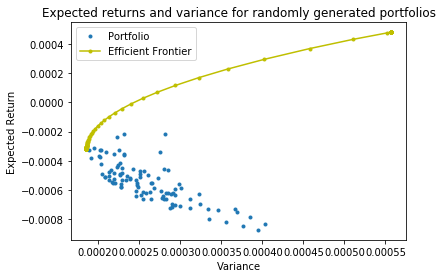

In [86]:
## find efficient frontier
# generate random portfolio, see random_portfolio notebook
np.random.seed(2) # fixed random seed
n_portfolio = 100 # number of portfolios
n_asset = len(assets) # number of assets 3
rand_matrix = np.random.random((n_portfolio, n_asset)) # generate random matrix
portfolio = np.zeros((n_portfolio, n_asset)) # create portfolios
i = 0
for row in rand_matrix: # each portfolio sum up to 1
    row_sum = np.sum(row)
    j = 0
    for col in row:
        portfolio[i][j] = col/row_sum
        j += 1
    i += 1
E = np.dot(portfolio, assets) # find expected return of each portfolio
variance = np.zeros((n_portfolio, 1)) # find variance of all portfolio
i = 0
for row in portfolio:
    variance[i] = np.dot(np.dot(row, C), row.T)
    i += 1
    
fig, ax = plt.subplots()
plotfolios = ax.plot(variance, E, 'o', markersize=3, label='Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for randomly generated portfolios')

N = 100
# points = [t for t in range(N)] # find max return for 100 points
points = [10**(5.0 * t/N - 1.0) for t in range(N)]
S = opt.matrix(C)
q = opt.matrix(assets, (3, 1)) # mean return of 3 assets

G = -opt.matrix(np.eye(n_asset)) # all 3 portions >= 0
oo = opt.matrix([-G, G], (6, 3))
h = opt.matrix(1.0, (6, 1))
A = opt.matrix(1.0, (1, n_asset)) # all 3 portions sum to 1
b = opt.matrix(1.0)

portfolios = [solvers.qp(x*S, -q, oo, h, A, b)['x'] for x in points]
returns = [blas.dot(q, x) for x in portfolios] # for each efficient portfolio
risks = [blas.dot(x, S*x) for x in portfolios]

frontier = ax.plot(risks, returns, 'y-o', markersize=3, label='Efficient Frontier')
ax.legend(loc='best')

In [87]:
assets2 = []
# take second half of assets
def half2_expected_return(df, assets):
    df = df[len(df)/2:] # drop first half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets2.append(returns.mean())
    return returns
returns1 = half2_expected_return(df1, assets2)
print assets2
# print returns1

[0.00019738336515455533]


In [88]:
returns2 = half2_expected_return(df2, assets2)
print assets2

[0.00019738336515455533, 0.0005493144332658916]


In [89]:
returns3 = half2_expected_return(df3, assets2)
print assets2

[0.00019738336515455533, 0.0005493144332658916, 0.0004787492131779681]


In [90]:
# find covariance of 3 assets second half
C2 = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C2

[[1.47726381e-04 1.74528546e-05 2.28007995e-05]
 [1.74528546e-05 1.99561592e-04 4.14745374e-06]
 [2.28007995e-05 4.14745374e-06 1.13009048e-04]]


Text(0.5,1,u'Expected returns and variance for naive portfolios')

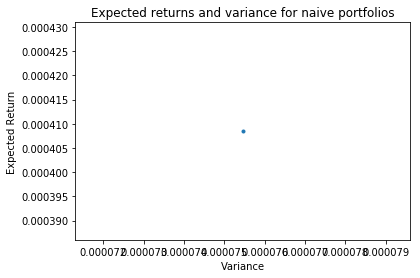

In [91]:
n_portfolio = 1 # number of portfolios
n_asset = len(assets2) # number of assets 3
naive = np.full((n_portfolio, n_asset), 1.0/3) # generate Naive Diversification
E = np.dot(naive, assets2) # find expected return of each portfolio
variance2 = np.dot(np.dot(row, C2), row.T) # find variance of all portfolio
variance2

fig2, ax2 = plt.subplots()
plotfolios2 = ax2.plot(variance2, E, 'o', markersize=3, label='Naive Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for naive portfolios')

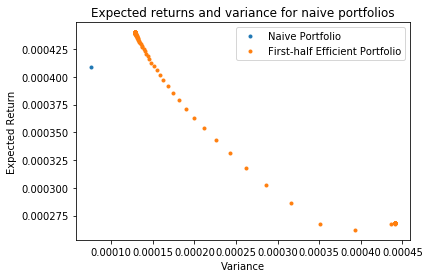

In [92]:
# apply first half efficient portfolios to second half
qn = opt.matrix(assets2, (3, 1))
Sn = opt.matrix(C2)
ef1 = [blas.dot(qn, x) for x in portfolios]
risks1 = [blas.dot(x, Sn*x) for x in portfolios]
ax2.plot(risks1, ef1, 'o', markersize=3, label='First-half Efficient Portfolio')
ax2.legend(loc='best')
fig2